In [1]:
from pathlib import Path
import re

In [2]:
import os 
os.listdir()

['.ipynb_checkpoints',
 'atis-clean.dev.pkl.gz',
 'atis-clean.dev.w-intent.iob',
 'atis-clean.test.pkl.gz',
 'atis-clean.test.w-intent.iob',
 'atis-clean.train.pkl.gz',
 'atis-clean.train.w-intent.iob',
 'ATIS_df_test.pkl',
 'ATIS_df_train.pkl',
 'ATIS_df_val.pkl',
 'ATIS_from_MSCNTK_RAWDATA',
 'ATIS_MSCNKT_Dataset.ipynb',
 'ATIS_MSCNTK_MODELS',
 'BERT_EntityExtraction_FineTune_ATIS-Native_TF_Training.ipynb',
 'BERT_EntityExtraction_FineTune_ATIS.ipynb',
 'LOAD_BERT_EntityExtraction.ipynb',
 'logs',
 'MS CNTK ATIS Dataset Resplit.ipynb',
 'MS CNTK ATIS Dataset to Pandas DataFrame.ipynb']

In [3]:
f = 'atis-clean.train.w-intent.iob'
#print(os.path.exists(f))
f_path = Path(f)
raw_text = f_path.read_text().strip()
print(raw_text[0:366])
raw_docs = re.split('\n', raw_text)[1:]
for i in range(len(raw_docs)):
    raw_docs[i] = raw_docs[i] + '\n'
raw_docs[0]

BOS what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth EOS	O O O O O O O B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name O O B-depart_date.month_name B-depart_date.day_number I-depart_date.day_number O O O B-return_date.month_name B-return_date.day_number atis_airfare



'BOS now i need a flight leaving fort worth and arriving in denver no later than 2 pm next monday EOS\tO O O O O O O B-fromloc.city_name I-fromloc.city_name O O O B-toloc.city_name B-arrive_time.time_relative I-arrive_time.time_relative I-arrive_time.time_relative B-arrive_time.time I-arrive_time.time B-arrive_date.date_relative B-arrive_date.day_name atis_flight\n'

In [4]:
####################################################################
def read_data(file_path):
    file_path = Path(file_path)
    
    raw_text = file_path.read_text().strip()
    raw_docs = re.split('\n', raw_text)
    
    #for i in range(len(raw_docs)):
        #raw_docs[i] = raw_docs[i] + '\n'
        
    token_docs = []
    tag_docs = []
    label_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        labels = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            string = str(tag)
            label = string[string.find('atis'):]
            tag = [string[:string.find('atis')-1]][0]
            tokens.append(token)
            tags.append(tag)
            labels.append(label)
        label_docs.append(labels)
        token_docs.append(tokens)
        tag_docs.append(tags)
    return token_docs, tag_docs, label_docs

In [5]:
train_data_path = 'atis-clean.train.w-intent.iob'
val_data_path = 'atis-clean.dev.w-intent.iob'
test_data_path = 'atis-clean.test.w-intent.iob'

train_texts, train_tags, train_intents = read_data(train_data_path)
val_texts, val_tags, val_intents = read_data(val_data_path)
test_texts, test_tags, test_intents = read_data(test_data_path)

In [6]:
import pandas as pd
dict_train = {'intent': train_intents, 'tag': train_tags, 'text': train_texts}
df_train = pd.DataFrame(dict_train)

dict_val = {'intent': val_intents, 'tag': val_tags, 'text': val_texts}
df_val = pd.DataFrame(dict_val)

dict_test = {'intent': test_intents, 'tag': test_tags, 'text': test_texts}
df_test = pd.DataFrame(dict_test)

In [7]:
df_test.head()

,intent,tag,text
0,[atis_flight],[O O O O B-class_type O O B-fromloc.city_name ...,[BOS what are the coach flights between dallas...
1,[atis_flight],[O O O O O O B-fromloc.city_name O B-toloc.cit...,[BOS i want a flight from nashville to seattle...
2,[atis_flight],[O O O O O O B-fromloc.city_name I-fromloc.cit...,[BOS i need a flight leaving kansas city to ch...
3,[atis_abbreviation],[O O B-meal O B-meal_code I-meal_code],[BOS explain meal codes sd d EOS]
4,[atis_flight],[O O O O O O B-fromloc.city_name O B-toloc.cit...,[BOS show me all flights from atlanta to san f...


In [8]:
df_test["text"].tolist()[0]

['BOS what are the coach flights between dallas and baltimore leaving august tenth and returning august twelve EOS']

In [9]:
#save as .pkl to avoid formatting errors
df_train.to_pickle('ATIS_df_train.pkl')
df_test.to_pickle('ATIS_df_test.pkl')
df_val.to_pickle('ATIS_df_val.pkl')

In [10]:
import numpy as np
n = np.random.randint(len(test_texts))
print(test_texts[n], test_tags[n], test_intents[n], sep='\n')

['BOS how many flights does twa have with business class EOS']
['O O O O O B-airline_code O O B-class_type I-class_type']
['atis_quantity']


# DATA ANALYSIS

In [11]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [13]:
label_count = df_train.intent.str.join('')
label_count.unique()

array(['atis_airfare', 'atis_flight', 'atis_abbreviation',
       'atis_ground_service', 'atis_restriction', 'atis_airport',
       'atis_quantity', 'atis_meal', 'atis_airline', 'atis_city',
       'atis_flight_no', 'atis_ground_fare', 'atis_flight_time',
       'atis_flight#atis_airfare', 'atis_distance', 'atis_aircraft',
       'atis_capacity'], dtype=object)

C:\Users\fghanem.FADIGHANEM\anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


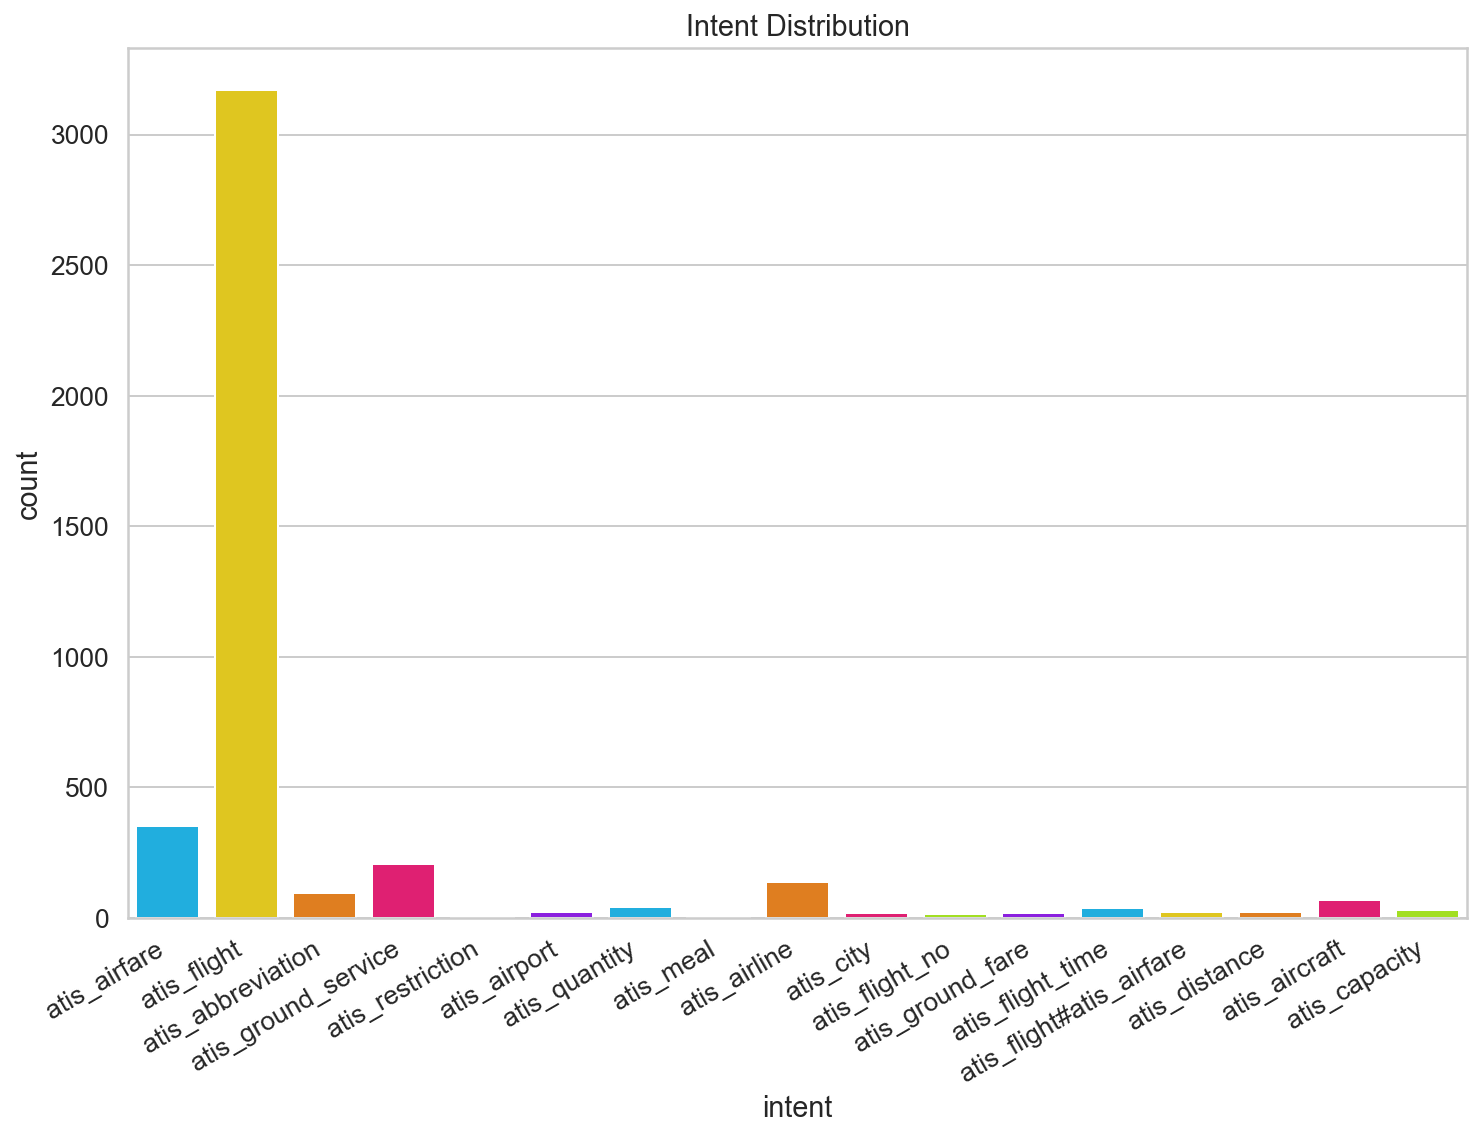

In [14]:
chart = sns.countplot(label_count, palette=HAPPY_COLORS_PALETTE)
plt.title("Intent Distribution")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');